# Prédicition de la variable de la consommation d'énergie des bâtiments de SEATTLE


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import missingno as msno
import FETCH_LOAD_DATAS
import ACP_functions

C:\Users\jkomb\anaconda3.2022\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 49
rng = np.random.default_rng(SEED)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
plt.rcParams['figure.figsize'] = [10, 8]

In [5]:
data = pd.read_csv("datasets/DF_EDA.csv")

In [6]:
df = data.copy()

In [7]:
df.drop(columns='TotalGHGEmissions', inplace=True)

In [8]:
IMAGES_PATH = Path() / "img" / "prediction_conso"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"prediction_conso - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [9]:
conso = 'SiteEnergyUse(kBtu)'

In [10]:
numerical_features = list(df.describe().columns)
numerical_features.remove(conso)

# Traitement des valeurs manquantes

In [11]:
df.head()

,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,GHGEmissionsIntensity
0,NonResidential,Hotel,Mayflower park hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,False,Compliant,2.83
1,NonResidential,Hotel,Paramount Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,False,Compliant,2.86
2,NonResidential,Hotel,5673-The Westin Seattle,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,False,Compliant,2.19
3,NonResidential,Hotel,HOTEL MAX,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,False,Compliant,4.67
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,False,Compliant,2.88


<AxesSubplot:>

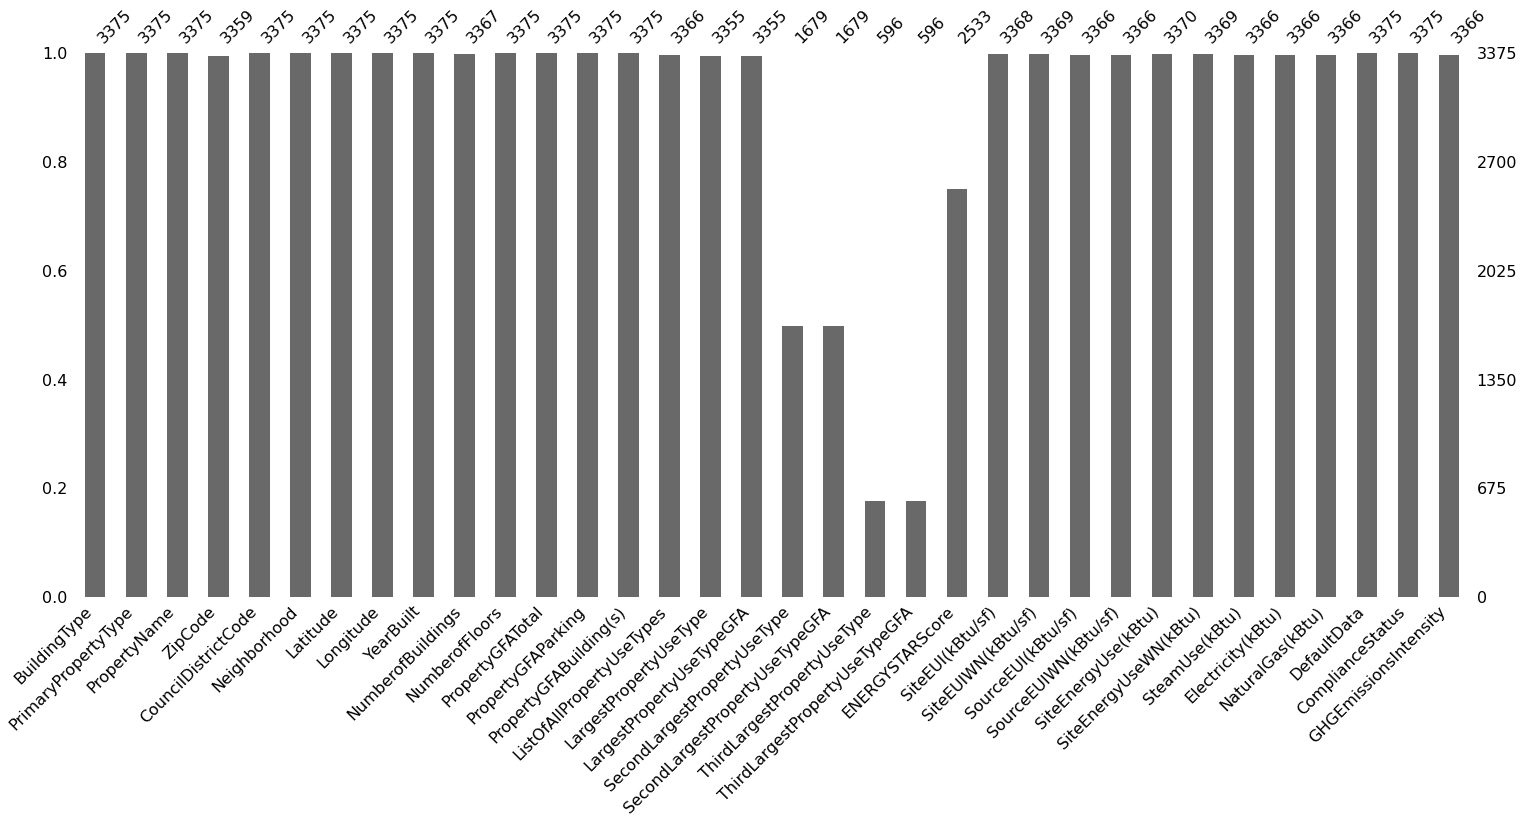

In [12]:
msno.bar(df)

Avant toue chose, comme le précise l'énoncé de mission, nous allons effectuer un tri pour ne conserver que les bâtiments non résidentiels du jeu de données.

In [13]:
df['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    23
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [14]:
df = df[~df['BuildingType'].str.contains('family')]

In [15]:
df.shape

(1667, 34)

Les bâtiments résidentiels sont également caractérisés par la présence du mot-clé **'family'** dans la liste de leur usage :

In [16]:
df['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [17]:
df = df[~df['PrimaryPropertyType'].fillna('').str.contains('family')]

In [18]:
df['ListOfAllPropertyUseTypes'].str.contains('family').value_counts()

False    1626
True       36
Name: ListOfAllPropertyUseTypes, dtype: int64

In [19]:
df = df[~df['ListOfAllPropertyUseTypes'].fillna('').str.contains('family')]

In [20]:
df.shape

(1628, 34)

In [21]:
df['LargestPropertyUseType'].str.contains('family').value_counts()

False    1622
Name: LargestPropertyUseType, dtype: int64

In [22]:
df['SecondLargestPropertyUseType'].str.contains('family').value_counts()

False    817
Name: SecondLargestPropertyUseType, dtype: int64

In [23]:
df['ThirdLargestPropertyUseType'].str.contains('family').value_counts()

False    319
Name: ThirdLargestPropertyUseType, dtype: int64

<AxesSubplot:>

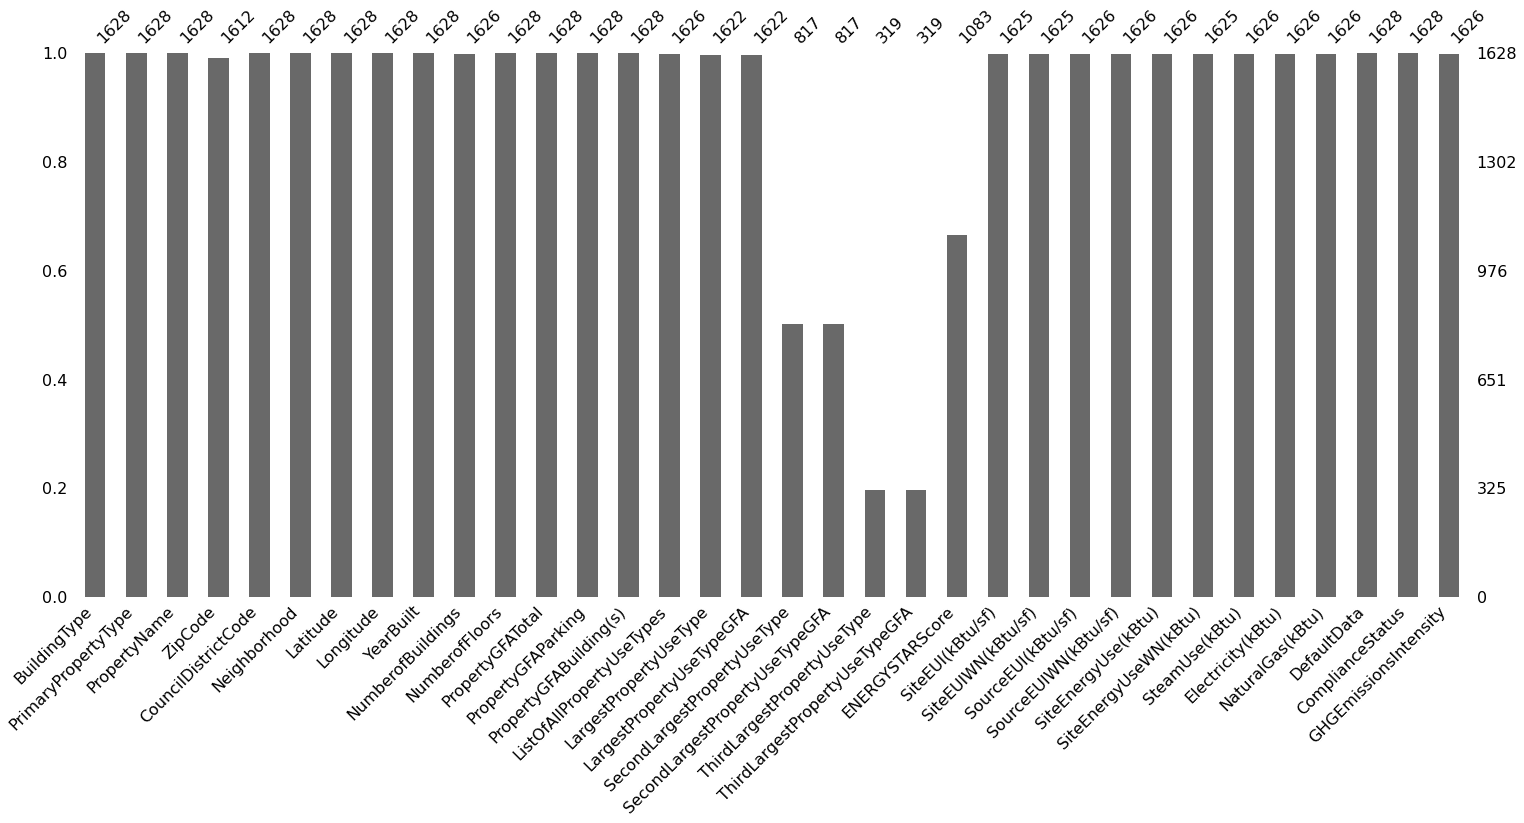

In [24]:
msno.bar(df)

In [25]:
df.isna().mean().mean()

0.0874403815580286

In [26]:
df.reset_index(inplace=True, drop=True)

Pour le traitement des données manquantes, nous allons tout simplement procéder colonne par colonne, de gauche à droite du jeu de données :

In [27]:
df.isna().mean()[df.isna().mean()!=0.]

ZipCode                            0.009828
NumberofBuildings                  0.001229
ListOfAllPropertyUseTypes          0.001229
LargestPropertyUseType             0.003686
LargestPropertyUseTypeGFA          0.003686
SecondLargestPropertyUseType       0.498157
SecondLargestPropertyUseTypeGFA    0.498157
ThirdLargestPropertyUseType        0.804054
ThirdLargestPropertyUseTypeGFA     0.804054
ENERGYSTARScore                    0.334767
SiteEUI(kBtu/sf)                   0.001843
SiteEUIWN(kBtu/sf)                 0.001843
SourceEUI(kBtu/sf)                 0.001229
SourceEUIWN(kBtu/sf)               0.001229
SiteEnergyUse(kBtu)                0.001229
SiteEnergyUseWN(kBtu)              0.001843
SteamUse(kBtu)                     0.001229
Electricity(kBtu)                  0.001229
NaturalGas(kBtu)                   0.001229
GHGEmissionsIntensity              0.001229
dtype: float64

Nous allons nous séparer de la colonne **'ZipCode'** qui nous donne une information similaire que la colonne **'CouncilDistrictCode'** tout en étant plus difficile à interpréter. 

De même, nous allons suppprimer les colonnes **'DefaultData'** et **'ComplianceStatus'** car elles ne sont pas informatives pour notre problématique.

In [28]:
df.drop(columns=['ZipCode','DefaultData', 'ComplianceStatus'], inplace=True)
numerical_features.remove('ZipCode')

In [29]:
df[df['NumberofBuildings'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
559,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,NonResidential,Mixed Use Property,KALBERG BUILDING,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous décidons de supprimer ces 2 entrées de notre jeu de données car elles possèdent trop de valeurs manquantes parmi les variables de consommation d'énergie/émission de gaz à effet de serre.

In [30]:
df.drop(index=df[df['NumberofBuildings'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [31]:
df.isna().mean()[df.isna().mean()!=0.]

LargestPropertyUseType             0.002460
LargestPropertyUseTypeGFA          0.002460
SecondLargestPropertyUseType       0.497540
SecondLargestPropertyUseTypeGFA    0.497540
ThirdLargestPropertyUseType        0.803813
ThirdLargestPropertyUseTypeGFA     0.803813
ENERGYSTARScore                    0.333948
SiteEUI(kBtu/sf)                   0.000615
SiteEUIWN(kBtu/sf)                 0.000615
SiteEnergyUseWN(kBtu)              0.000615
dtype: float64

In [32]:
df[df['LargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
344,NonResidential,Self-Storage Facility,Market St Center,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,3007514.0,2689958.0,1.47
806,NonResidential,Hotel,Palladian Hotel,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,93.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,2534592.0,362488.0,0.60
1323,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,NaN,NaN,NaN,NaN,45.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,3168131.0,0.0,0.46
1340,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,402907.0,497017.0,1.01


In [33]:
df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('LargestPropertyUseType')] = df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('ListOfAllPropertyUseTypes')].apply(lambda x: x.split(',')[0])

In [34]:
df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('LargestPropertyUseTypeGFA')] = df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('PropertyGFATotal')]

In [35]:
df.isna().mean()[df.isna().mean()!=0.]

SecondLargestPropertyUseType       0.497540
SecondLargestPropertyUseTypeGFA    0.497540
ThirdLargestPropertyUseType        0.803813
ThirdLargestPropertyUseTypeGFA     0.803813
ENERGYSTARScore                    0.333948
SiteEUI(kBtu/sf)                   0.000615
SiteEUIWN(kBtu/sf)                 0.000615
SiteEnergyUseWN(kBtu)              0.000615
dtype: float64

In [36]:
df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    804
4      4
3      1
Name: LargestPropertyUseType, dtype: int64

In [37]:
df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    1301
4       5
3       1
Name: LargestPropertyUseType, dtype: int64

Nous pouvons constater dans les 2 dernières cellules, que les valeurs manquantes des colonnes **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent être principalement mises à la valeur **0** car elles correspondent à des portefeuilles de bâtiments n'ayant qu'un seul usage pour la très grande majorité :

In [38]:
df[df['SecondLargestPropertyUseType'].isna()][df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
105,Nonresidential COS,Other,CSC Vehicle Maintenance (E),2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,3.03
1138,NonResidential,Other,Performance Radiator,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,0.47
1289,NonResidential,Other,4H Investments,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,1.65
1487,NonResidential,Other,AKER'S VOLKS-PORSCHE REPAIR (ID27825),3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,0.22
1585,Nonresidential COS,Other,First Hill Street Car Maintenance Shop,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,0.51


In [39]:
df[df['ThirdLargestPropertyUseType'].isna()][df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
105,Nonresidential COS,Other,CSC Vehicle Maintenance (E),2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,3.03
1031,NonResidential,Other,Laidlaw,1,DELRIDGE,47.533660,-122.337330,1963,1.0,1,23260,0,23260,"Office, Repair Services (Vehicle, Shoe, Locksm...","Repair Services (Vehicle, Shoe, Locksmith, etc)",13075.0,Office,10185.0,NaN,NaN,NaN,69.300003,77.500000,137.399994,146.100006,1.612106e+06,1.803515e+06,0.0,719779.0,892327.0,2.25
1138,NonResidential,Other,Performance Radiator,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,0.47
1289,NonResidential,Other,4H Investments,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,1.65
1487,NonResidential,Other,AKER'S VOLKS-PORSCHE REPAIR (ID27825),3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,0.22
1585,Nonresidential COS,Other,First Hill Street Car Maintenance Shop,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,0.51


Nous constatons dans les 2 dernières cellules que les portefeuilles de bâtiments 'problématiques' ont des valeurs de **'PropertyGFATotal'** et **'LargestPropertyUseTypeGFA'** identiques, sauf pour le portefeuille de bâtiment déclinant un second usage de ses surfaces.

Nous considérons donc que les valeurs manquantes des colonnes :
   - **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent être mises à **None** (pas d'autre usage des surfaces du bâtiment que l'usage principal)
   - **'SecondLargestPropertyUseTypeGFA'** et **'ThirdLargestPropertyUseTypeGFA'** peuvent être mises à **0**

In [40]:
df['SecondLargestPropertyUseType'].fillna('None', inplace=True)
df['ThirdLargestPropertyUseType'].fillna('None', inplace=True)
df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

In [41]:
df.isna().mean()[df.isna().mean()!=0.]

ENERGYSTARScore          0.333948
SiteEUI(kBtu/sf)         0.000615
SiteEUIWN(kBtu/sf)       0.000615
SiteEnergyUseWN(kBtu)    0.000615
dtype: float64

In [42]:
df[df['SiteEUI(kBtu/sf)'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
295,NonResidential,Other,Washington State Convention Center,7,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,None,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous décidons de supprimer cette entrée car elle manque d'un trop grand nombre de valeurs pour nos variables pertinentes (dont nos valeurs cibles).

In [43]:
df.drop(index=df[df['SiteEUI(kBtu/sf)'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [44]:
df[df['SiteEUIWN(kBtu/sf)'].isna()]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
543,NonResidential,Large Office,Market Place I & II-2003 Western Avenue,7,DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,87160,43983,"Office, Retail Store",Office,120248.0,Retail Store,10853.0,None,0.0,93.0,39.5,NaN,128.0,0.0,5177270.5,NaN,0.0,4871126.0,1416041.0,0.83


In [45]:
df.corr()[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']].loc[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']]

,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu)
SiteEUI(kBtu/sf),1.000000,0.993558,0.376077,0.367564
SiteEUIWN(kBtu/sf),0.993558,1.000000,0.365500,0.365022
SiteEnergyUse(kBtu),0.376077,0.365500,1.000000,0.996813
SiteEnergyUseWN(kBtu),0.367564,0.365022,0.996813,1.000000


Étant donné le très grand coefficient de corrélation linéaire entre les paires de colonnes **('SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)')** et **('SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)')** (>0,99), nous allons tout simplement imputer la valeur manquante dans la colonns **SiteEUIWN(kBtu/sf)** et la colonne **SiteEnergyUseWN(kBtu)** en entraînant une régression linéaire au sein de chacune des paires de variables citées ci-avant :

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut

In [47]:
y_1 = df[df['SiteEUIWN(kBtu/sf)'].notna()]['SiteEUIWN(kBtu/sf)']
X_1 = df[df['SiteEUIWN(kBtu/sf)'].notna()]['SiteEUI(kBtu/sf)'].to_numpy().reshape(-1, 1)

y_2 = df[df['SiteEnergyUseWN(kBtu)'].notna()]['SiteEnergyUseWN(kBtu)']
X_2 = df[df['SiteEnergyUseWN(kBtu)'].notna()]['SiteEnergyUse(kBtu)'].to_numpy().reshape(-1, 1)

In [48]:
lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()

In [49]:
cv=10

In [50]:
cross_score_1 = cross_val_score(lin_reg_1, StandardScaler().fit_transform(X_1), y_1, scoring='r2', 
                                cv=KFold(n_splits=cv, shuffle=True, random_state=SEED))
cross_score_2 = cross_val_score(lin_reg_2, StandardScaler().fit_transform(X_2), y_2, scoring='r2', 
                                cv=KFold(n_splits=cv, shuffle=True, random_state=SEED))

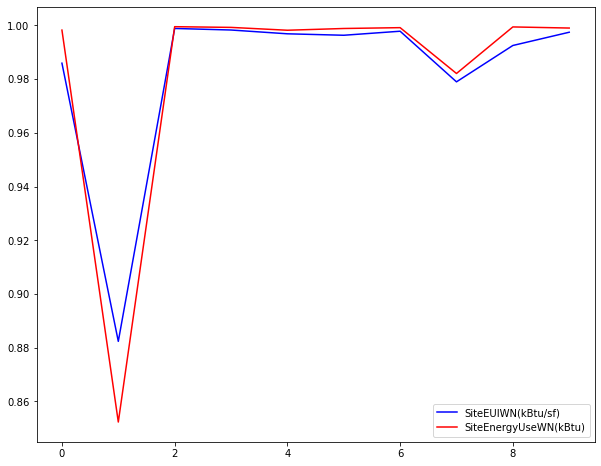

In [51]:
plt.plot(list(range(0,cv)),cross_score_1, color='blue', label='SiteEUIWN(kBtu/sf)')
plt.plot(list(range(0,cv)),cross_score_2, color='red', label='SiteEnergyUseWN(kBtu)')
plt.legend();

Nous pensons à ce stade que les chutes du score R² dans les courbes ci-avant sont dûes aux outliers présents dans les colonnes **SiteEUIWN(kBtu/sf)** et **SiteEnergyUseWN(kBtu)** :

<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)'>

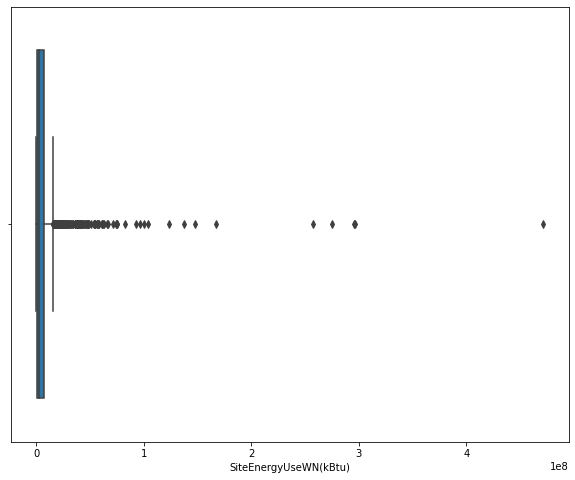

In [52]:
sns.boxplot(x=df[df['SiteEnergyUseWN(kBtu)'].notna()]['SiteEnergyUseWN(kBtu)'])

<AxesSubplot:xlabel='SiteEUIWN(kBtu/sf)'>

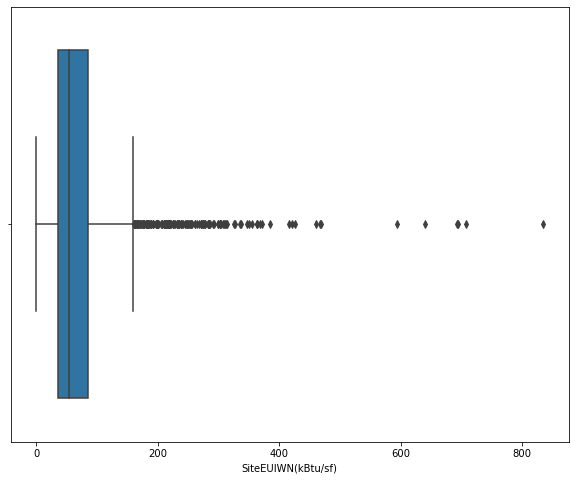

In [53]:
sns.boxplot(x=df[df['SiteEUIWN(kBtu/sf)'].notna()]['SiteEUIWN(kBtu/sf)'])

Mais cela ne nous dérange pas vraiment pour l'imputation d'une valeur unique dans chacune de ces colonnes, le score R² est globalement très bon, comme on pouvait s'en douter.

In [54]:
cross_score_1.mean(), cross_score_2.mean()

(0.9825740621594997, 0.982640935302603)

In [55]:
lin_reg_1.fit(StandardScaler().fit_transform(X_1), y_1)
lin_reg_2.fit(StandardScaler().fit_transform(X_2), y_2)

LinearRegression()

In [56]:
df.loc[df[df['SiteEUIWN(kBtu/sf)'].isna()].index,'SiteEUIWN(kBtu/sf)'] = lin_reg_1.predict(df[df['SiteEUIWN(kBtu/sf)'].isna()]['SiteEUI(kBtu/sf)'].to_numpy().reshape(1, -1))
df.loc[df[df['SiteEnergyUseWN(kBtu)'].isna()].index,'SiteEnergyUseWN(kBtu)'] = lin_reg_2.predict(df[df['SiteEnergyUseWN(kBtu)'].isna()]['SiteEnergyUse(kBtu)'].to_numpy().reshape(1, -1))

In [57]:
df.isna().mean()[df.isna().mean()!=0.]

ENERGYSTARScore    0.333538
dtype: float64

<AxesSubplot:>

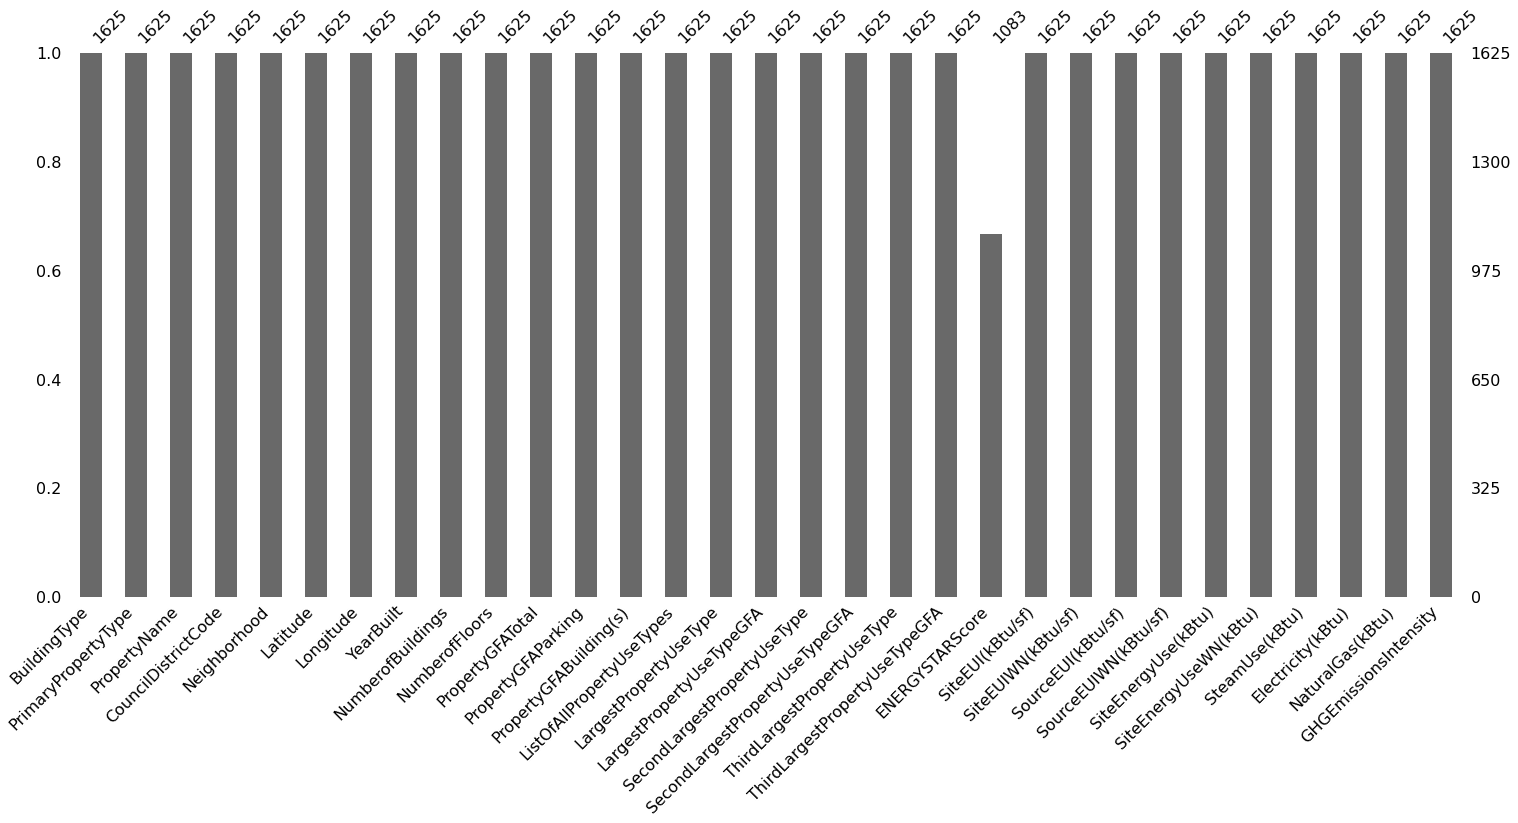

In [58]:
msno.bar(df)

Pour le traitement des valeurs manquantes de la colonne **ENERGYSTARScore**, nous allons tout d'abord restreindre le jeu de données à l'ensemble des portefeuilles des bâtiments n'ayant pas de valeur manquante dans cette colonne, puis nous allons amputer des valeurs à la colonne **ENERGYSTARScore** et comparer les valeurs imputées par différentes méthodes aux valeurs initiales.

La méthode ayant effectué les meilleurs imputations sur l'ensemble de jeux de données de validation que nous allons générer, sera retenue pour réaliser l'imputation des valeurs manquantes de la colonne entière.

Mais avant toute chose, nous séparons notre jeu de données en un jeu d'entraînement et un jeu de test afin de prévenir la fuite de données :

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=conso), df[conso], test_size=0.2, random_state=23*SEED)

In [61]:
X_train['ENERGYSTARScore'].isna().mean(), X_test['ENERGYSTARScore'].isna().mean()

(0.33076923076923076, 0.3446153846153846)

Nous avons des taux de valeurs manquantes similaires dans nos jeux d'entraînement et de test, ce qui est rassurant, sinon nous aurions dû effectuer un découpage stratifié pour équilibrer ces valeurs.

En effet, la méthode d'imputation choisie le sera dans le contexte d'un certain taux de valeurs manquantes, pour un taux très différent, et surtout plus élevé, la méthode choisie pourrait différer...

In [62]:
index_notna_ENERGYSTAR = X_train[X_train['ENERGYSTARScore'].notna()].index
df_select_imp = X_train.loc[index_notna_ENERGYSTAR, numerical_features]

<AxesSubplot:>

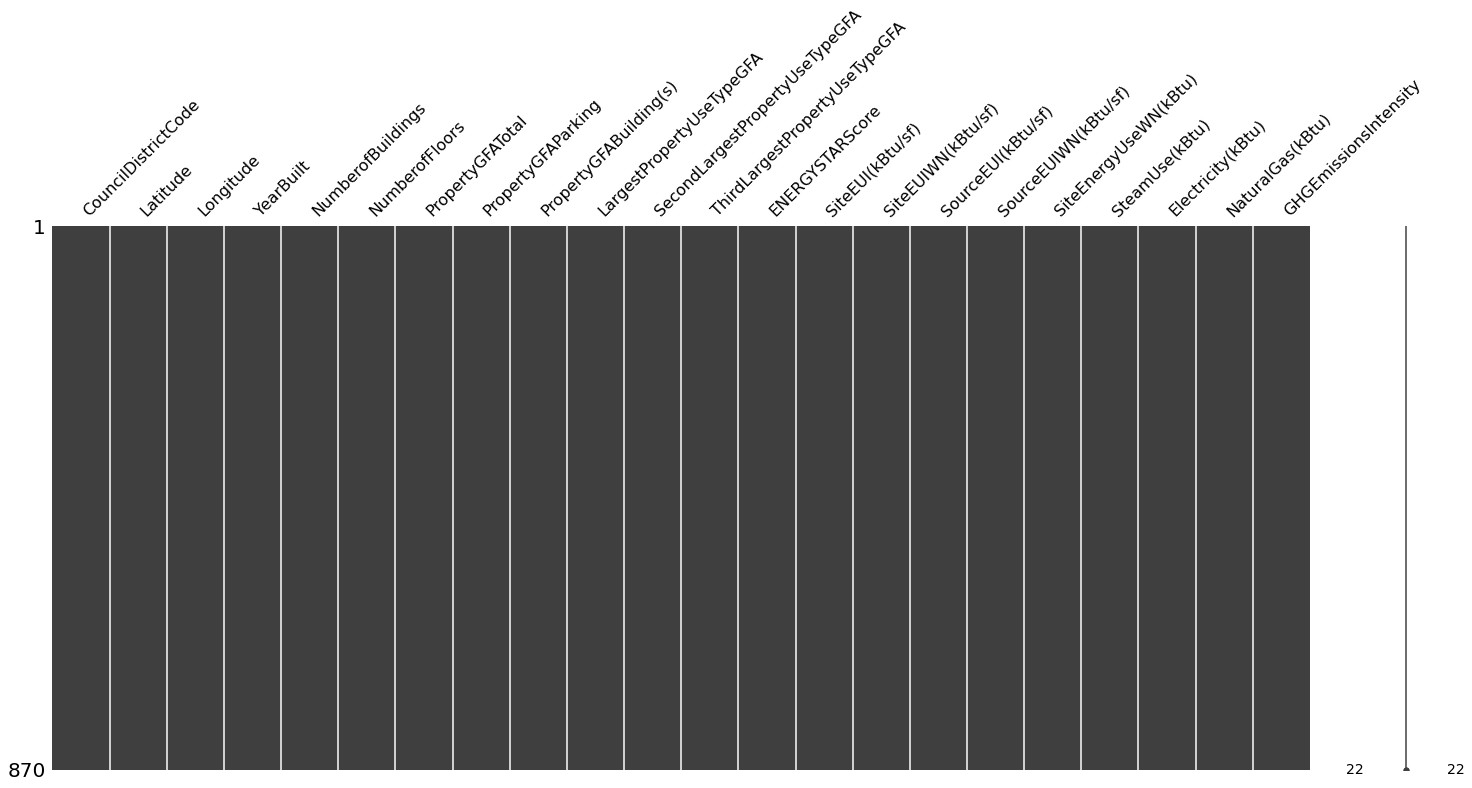

In [63]:
msno.matrix(df_select_imp)

Nous définissons dans un premier temps une fonction nous permettant d'amputer des valeurs dans un DataFrame et de stocker leurs indices pour une comparaison ultérieure des valeurs imputées avec les valeurs amputées.

In [64]:
def ampute_data(data,
                variables = None,
                pct_amp = 0.1,
                random_state = None):
    
    amputed_data = data.copy()
    amp_rows = int(pct_amp * data.shape[0])
    dict_index = dict()
    dict_index['amp_rows_size'] = amp_rows
    
    
    if random_state is None:
        rng = np.random.default_rng(seed=2022)
    else:
        rng = np.random.default_rng(seed=int(random_state))

    if variables is None:
        variables = [col for col in amputed_data.columns]
    elif isinstance(variables, list):
        if isinstance(variables[0], int):
            variables = [data.columns[i] for i in variables]
    
    dict_index['amp_total_size'] = amp_rows*len(variables)

    for v in variables:
        notna_index = amputed_data[amputed_data.loc[:,v].notna()].index
        amp_ind = rng.choice(notna_index, replace=False, size=amp_rows)
        amputed_data.loc[amp_ind, v] = np.nan
        dict_index[v]=amp_ind
    
    return amputed_data, dict_index

Nous définissons également une fonction nous permettant de visualiser la distribution de la variable **ENERGYSTARScore** avant et après imputation :

In [65]:
def plot_imputation(X_imputed):
    if isinstance(X_imputed, np.ndarray):
        X_imputed = pd.DataFrame(X_imputed, columns='ENERGYSTARScore')
    data = X_imputed.copy()
    col='ENERGYSTARScore'
    plt.figure(figsize=(12,18))

        
    sns.histplot(df_select_imp[col], stat='density', color='blue', alpha=0.6)
    sns.histplot(data[col], stat='density',  color='orange', alpha=0.4)
    
    plt.axvline(df_select_imp[col].mean(), color='green', ymin=0.5, alpha=0.5, label='moyenne initiale')
    plt.axvline(df_select_imp[col].median(), color='blue', ymin=0.5, alpha=0.5, label='médiane initiale')
    plt.axvline(data[col].mean(), color='red', ymax=0.4, alpha=0.9, label='nouvelle moyenne')
    plt.axvline(data[col].median(), color='black', ymax=0.4, alpha=0.5, label='nouvelle médiane')
    
    plt.legend(loc='upper left')
    
    plt.show()

Nous allons tester les méthodes d'imputation suivantes :
   1. **SimpleImputer** (imputation par la moyenne)
   2. **SimpleImputer** (imputation par la médiane)
   3. **KNNImputer** (k plus proche voisins allant de 1 à 15)
   4. **IterativeImputer**
   5. **MICE** (Multiple Imputation Chained Equations)

In [66]:
imputer_select_seeds = list(rng.integers(low=0, high=10000, size=5))

In [67]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf

from sklearn.metrics import mean_squared_error

Dans un premier temps nous générons un dictionnaire contenant 5 jeux de données avec différentes amputations de la colonne **ENERGYSTARScore**, ensuite nous imputerons ces différents jeux à l'aide des 3 méthodes citées plus haut afin de les comparer.

Nous allons utiliser un pourcentage d'imputation égal au taux de valeurs manquantes dans la colonne entière **ENERGYSTARScore** afin de nous rapprocher au plus des conditions dans lesquelles nous devrons véritablement utiliser l'imputation.

In [68]:
pct_amp = X_train['ENERGYSTARScore'].isna().mean()
pct_amp

0.33076923076923076

In [69]:
dict_df_amp = dict()

for seed in imputer_select_seeds:
    dict_df_amp[imputer_select_seeds.index(seed)] = tuple(ampute_data(df_select_imp, 
                                                                variables=['ENERGYSTARScore'], 
                                                                pct_amp=pct_amp, 
                                                                random_state=seed))

In [70]:
dict_mean_imputer = dict()

for key in dict_df_amp.keys():
    data = dict_df_amp[key][0].copy()
    mean_imputer = SimpleImputer()
    dict_mean_imputer[key] = pd.DataFrame(mean_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [71]:
dict_median_imputer = dict()

for key in dict_df_amp.keys():
    data = dict_df_amp[key][0].copy()
    median_imputer = SimpleImputer(strategy='median')
    dict_median_imputer[key] = pd.DataFrame(median_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [73]:
dict_knnimputer = dict()

for k in range(1,10):
    dict_knnimputer[k] = list()
    for key in dict_df_amp.keys():
        data = dict_df_amp[key][0].copy()
        knn_imputer = KNNImputer(n_neighbors=k, weights="uniform")
        dict_knnimputer[k].append(pd.DataFrame(knn_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index))

In [74]:
dict_iterativeimp = dict()

for key in dict_df_amp.keys():
        data = dict_df_amp[key][0].copy()
        iter_imp = IterativeImputer(random_state=SEED)
        dict_iterativeimp[key]= pd.DataFrame(iter_imp.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [75]:
dict_mice = dict()

# on instancie un nombre d'observation voisines de l'observation contenant la valeur manquante, à considérer comme candidat 
# pour baser notre l'imputation
scheme_candidate = mf.mean_match_default.copy()
scheme_candidate.set_mean_match_candidates(5)

for key in dict_df_amp.keys():
    dict_mice[key] = list()
    data = dict_df_amp[key][0].copy()
    # On crée le noyau
    kernel = mf.ImputationKernel(data,
                      datasets=4, # on crée 4 datasets d'imputations différents pour évaluer la distribution de l'imputation
                      mean_match_scheme=scheme_candidate,
                      save_all_iterations=True,
                      random_state=SEED)

    # on procède à 10 itérations de l'algorithme en espérant que les imputations convergent
    kernel.mice(10)
    
    dict_mice[key].append(kernel)
    dict_mice[key].append(kernel.complete_data())

Maintenant que nous avons tous nos jeux de données imputées, nous allons pouvoir calculer le score **Root Mean Square Error** obtenu sur chacun d'entre eux, ainsi que leur moyenne pour chacune des méthodes d'imputation :

In [76]:
list_rmse_mean = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_mean_imputer[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_mean.append(np.round(rmse,2))

In [77]:
list_rmse_median = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_median_imputer[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_median.append(np.round(rmse,2))

In [78]:
dict_rmse_knn = dict()

for k in range(1,10):
    dict_rmse_knn[k] = list()
    for key in dict_df_amp.keys():
        index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
        rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                      dict_knnimputer[k][key].loc[index_amp,'ENERGYSTARScore'], squared=False)
        dict_rmse_knn[k].append(np.round(rmse,2))

In [79]:
list_rmse_iter = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_iterativeimp[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_iter.append(np.round(rmse,2))

In [80]:
list_rmse_mice = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_mice[key][1].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_mice.append(np.round(rmse,2))

In [81]:
dict_comparison_imp = {'mean':list_rmse_mean,
                       'median':list_rmse_median,
                       'iterative':list_rmse_iter,
                       'mice':list_rmse_mice}

In [82]:
for key in dict_knnimputer.keys():
    comp_key = f"knn k={key}"
    dict_comparison_imp[comp_key]=dict_rmse_knn[key]

In [83]:
df_comp_imp = pd.DataFrame(dict_comparison_imp)

In [84]:
df_comp_imp

,mean,median,iterative,mice,knn k=1,knn k=2,knn k=3,knn k=4,knn k=5,knn k=6,knn k=7,knn k=8,knn k=9
0,28.55,29.65,27.28,23.15,38.51,32.20,30.16,29.68,29.64,28.94,28.66,28.38,27.87
1,27.23,28.22,433898.66,23.61,38.77,32.81,29.18,27.49,26.64,26.16,25.80,25.89,25.90
2,28.58,28.88,27.13,23.33,38.55,32.51,30.88,30.04,29.63,29.10,29.00,28.79,28.82
3,28.72,29.39,31.57,24.56,37.02,32.00,30.38,29.92,28.47,28.11,28.32,28.33,28.13
4,28.47,29.82,28.06,26.25,38.43,34.49,32.34,30.67,29.80,29.57,29.51,29.03,29.25


In [85]:
df_comp_imp.describe()

,mean,median,iterative,mice,knn k=1,knn k=2,knn k=3,knn k=4,knn k=5,knn k=6,knn k=7,knn k=8,knn k=9
count,5.000000,5.00000,5.00000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,28.310000,29.19200,86802.54000,24.180000,38.256000,32.802000,30.588000,29.56000,28.836000,28.376000,28.258000,28.084000,27.994000
std,0.610451,0.64913,194032.62977,1.278437,0.702339,0.992507,1.157981,1.21361,1.338144,1.346228,1.442678,1.260468,1.292142
min,27.230000,28.22000,27.13000,23.150000,37.020000,32.000000,29.180000,27.49000,26.640000,26.160000,25.800000,25.890000,25.900000
25%,28.470000,28.88000,27.28000,23.330000,38.430000,32.200000,30.160000,29.68000,28.470000,28.110000,28.320000,28.330000,27.870000
50%,28.550000,29.39000,28.06000,23.610000,38.510000,32.510000,30.380000,29.92000,29.630000,28.940000,28.660000,28.380000,28.130000
75%,28.580000,29.65000,31.57000,24.560000,38.550000,32.810000,30.880000,30.04000,29.640000,29.100000,29.000000,28.790000,28.820000
max,28.720000,29.82000,433898.66000,26.250000,38.770000,34.490000,32.340000,30.67000,29.800000,29.570000,29.510000,29.030000,29.250000


La meilleur méthode d'imputation est celle de l'algorithme **MICE**.

Regardons d'un peu plus près les caractéristiques de l'imputation qu'il génère :

In [92]:
# Nous choisissons le noyau généré par l'algorithme sur le 3ème jeu de données de validation
kernel = dict_mice[1][0]

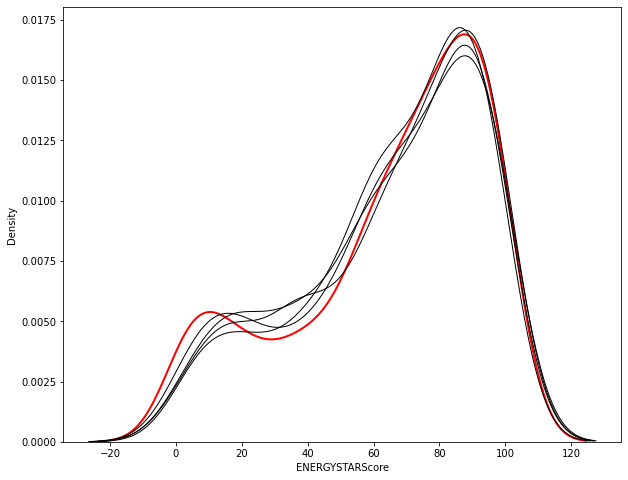

In [93]:
# Distribution de la variable imputée dans chacun des datasets (4) générés pour le deuxième jeu de donnée de validation

kernel.plot_imputed_distributions(wspace=0.3,
                                  hspace=0.3, 
                                  variables=['ENERGYSTARScore'])

Ci-dessous nous pouvons remarquer que l'algorithme converge très rapidement vers ses estimations finales !

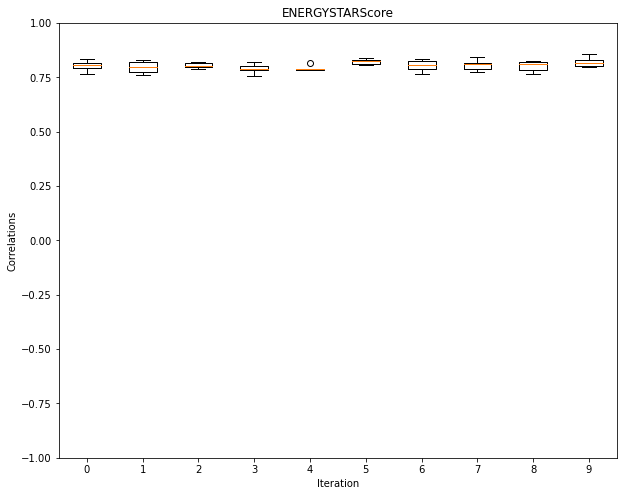

In [88]:
# Évolution de la distribution de la corrélation de distribution entre les datasets imputés et la distribution
# des données non manquantes

kernel.plot_correlations(variables=['ENERGYSTARScore'])

Ci-dessous nous pouvons observer qu'aucune variable ne sort du lot dans l'importance qu'elle revêt dans l'imputation de notre colonne **ENERGYSTARScore**. 

Cela ne nous étonne guère, car nous savons depuis la fin de l'analyse exploratoire qu'il s'agit de la variable la moins corrélée aux autres de toutes les variables numériques (voir illustration "exploration - 70" représentant les clusters de corrélations).

AxesSubplot(0.125,0.125;0.62x0.755)


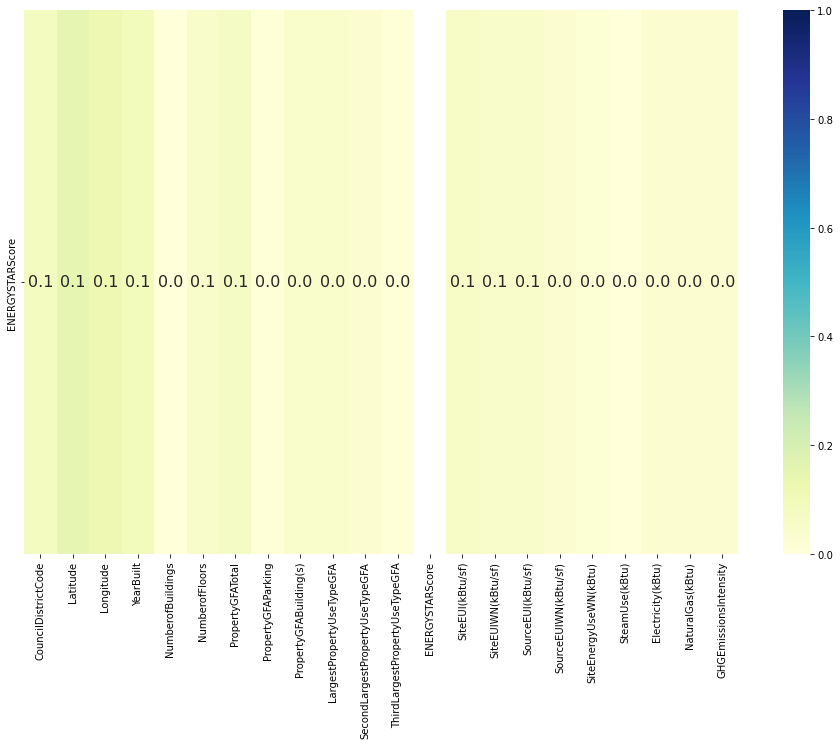

In [89]:
# Diagramme d'importance des variables dans l'imputation

plt.figure(figsize=(16,10))
kernel.plot_feature_importance(dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1,fmt=".1f")

Enfin, nous pouvons observer si la moyenne de nos imputations finit par converger.

Ici, cnous y sommes presque, il aurait peut-être fallu quelques itérations de plus pour arriver à une moyenne stable.

Cependant, étant donné que la convergence de la moyenne des imputations n'arrive pas dès les premières itérations, cela nous informe que les données manquantes étaient bien manquantes aléatoirement, et donc notre fonction d'amputation fait bien son travail.

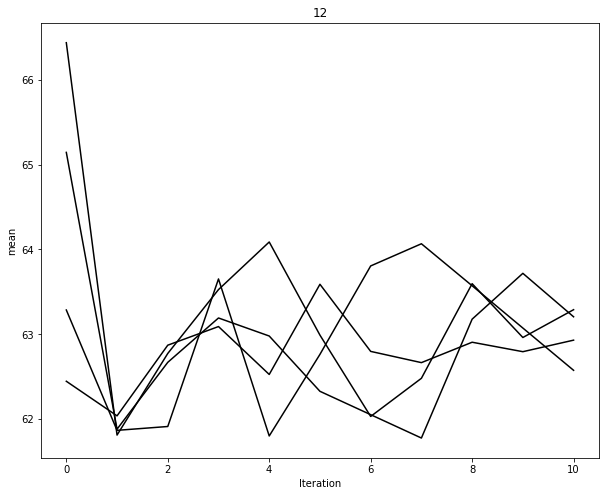

In [90]:
# Évolution des moyennes des imputations en fonction des itérations
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)

In [91]:
# ajouter des graphiques utilisant la fonction 'plot_imputation' pour illustrer !!!!!!!!!!